# LSTM

### Importing libraries and modules

In [ ]:
!pip install -U nbformat 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import statsmodels.api as sm
import padasip as pa

from sklearn.metrics import mean_squared_error, mean_absolute_error

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

import datetime

import wandb
import logging
import os

from codecarbon import EmissionsTracker

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import KFold, StratifiedKFold,TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from IPython.display import Image
from sklearn.linear_model import LinearRegression
from sklearn import tree
%config IPCompleter.greedy=True

In [3]:
import tensorflow as tf

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Implemented modules and Padasip module

In [5]:
from padasip.filters.base_filter import AdaptiveFilter
from TedaEnsemble import DataCloud, TEDAEnsemble

from treating import dataTreating, dataSpliting, dataProcessing, dataSplit

### Data loading:

In [6]:
data = pd.read_csv("Electric_Production.csv")
data.rename(columns={'DATE':'Date', 'IPG2211A2N':'Production'}, inplace=True)
data.head()

#Variables
dataSeries = data["Production"]
date = "Date"

### Visualization

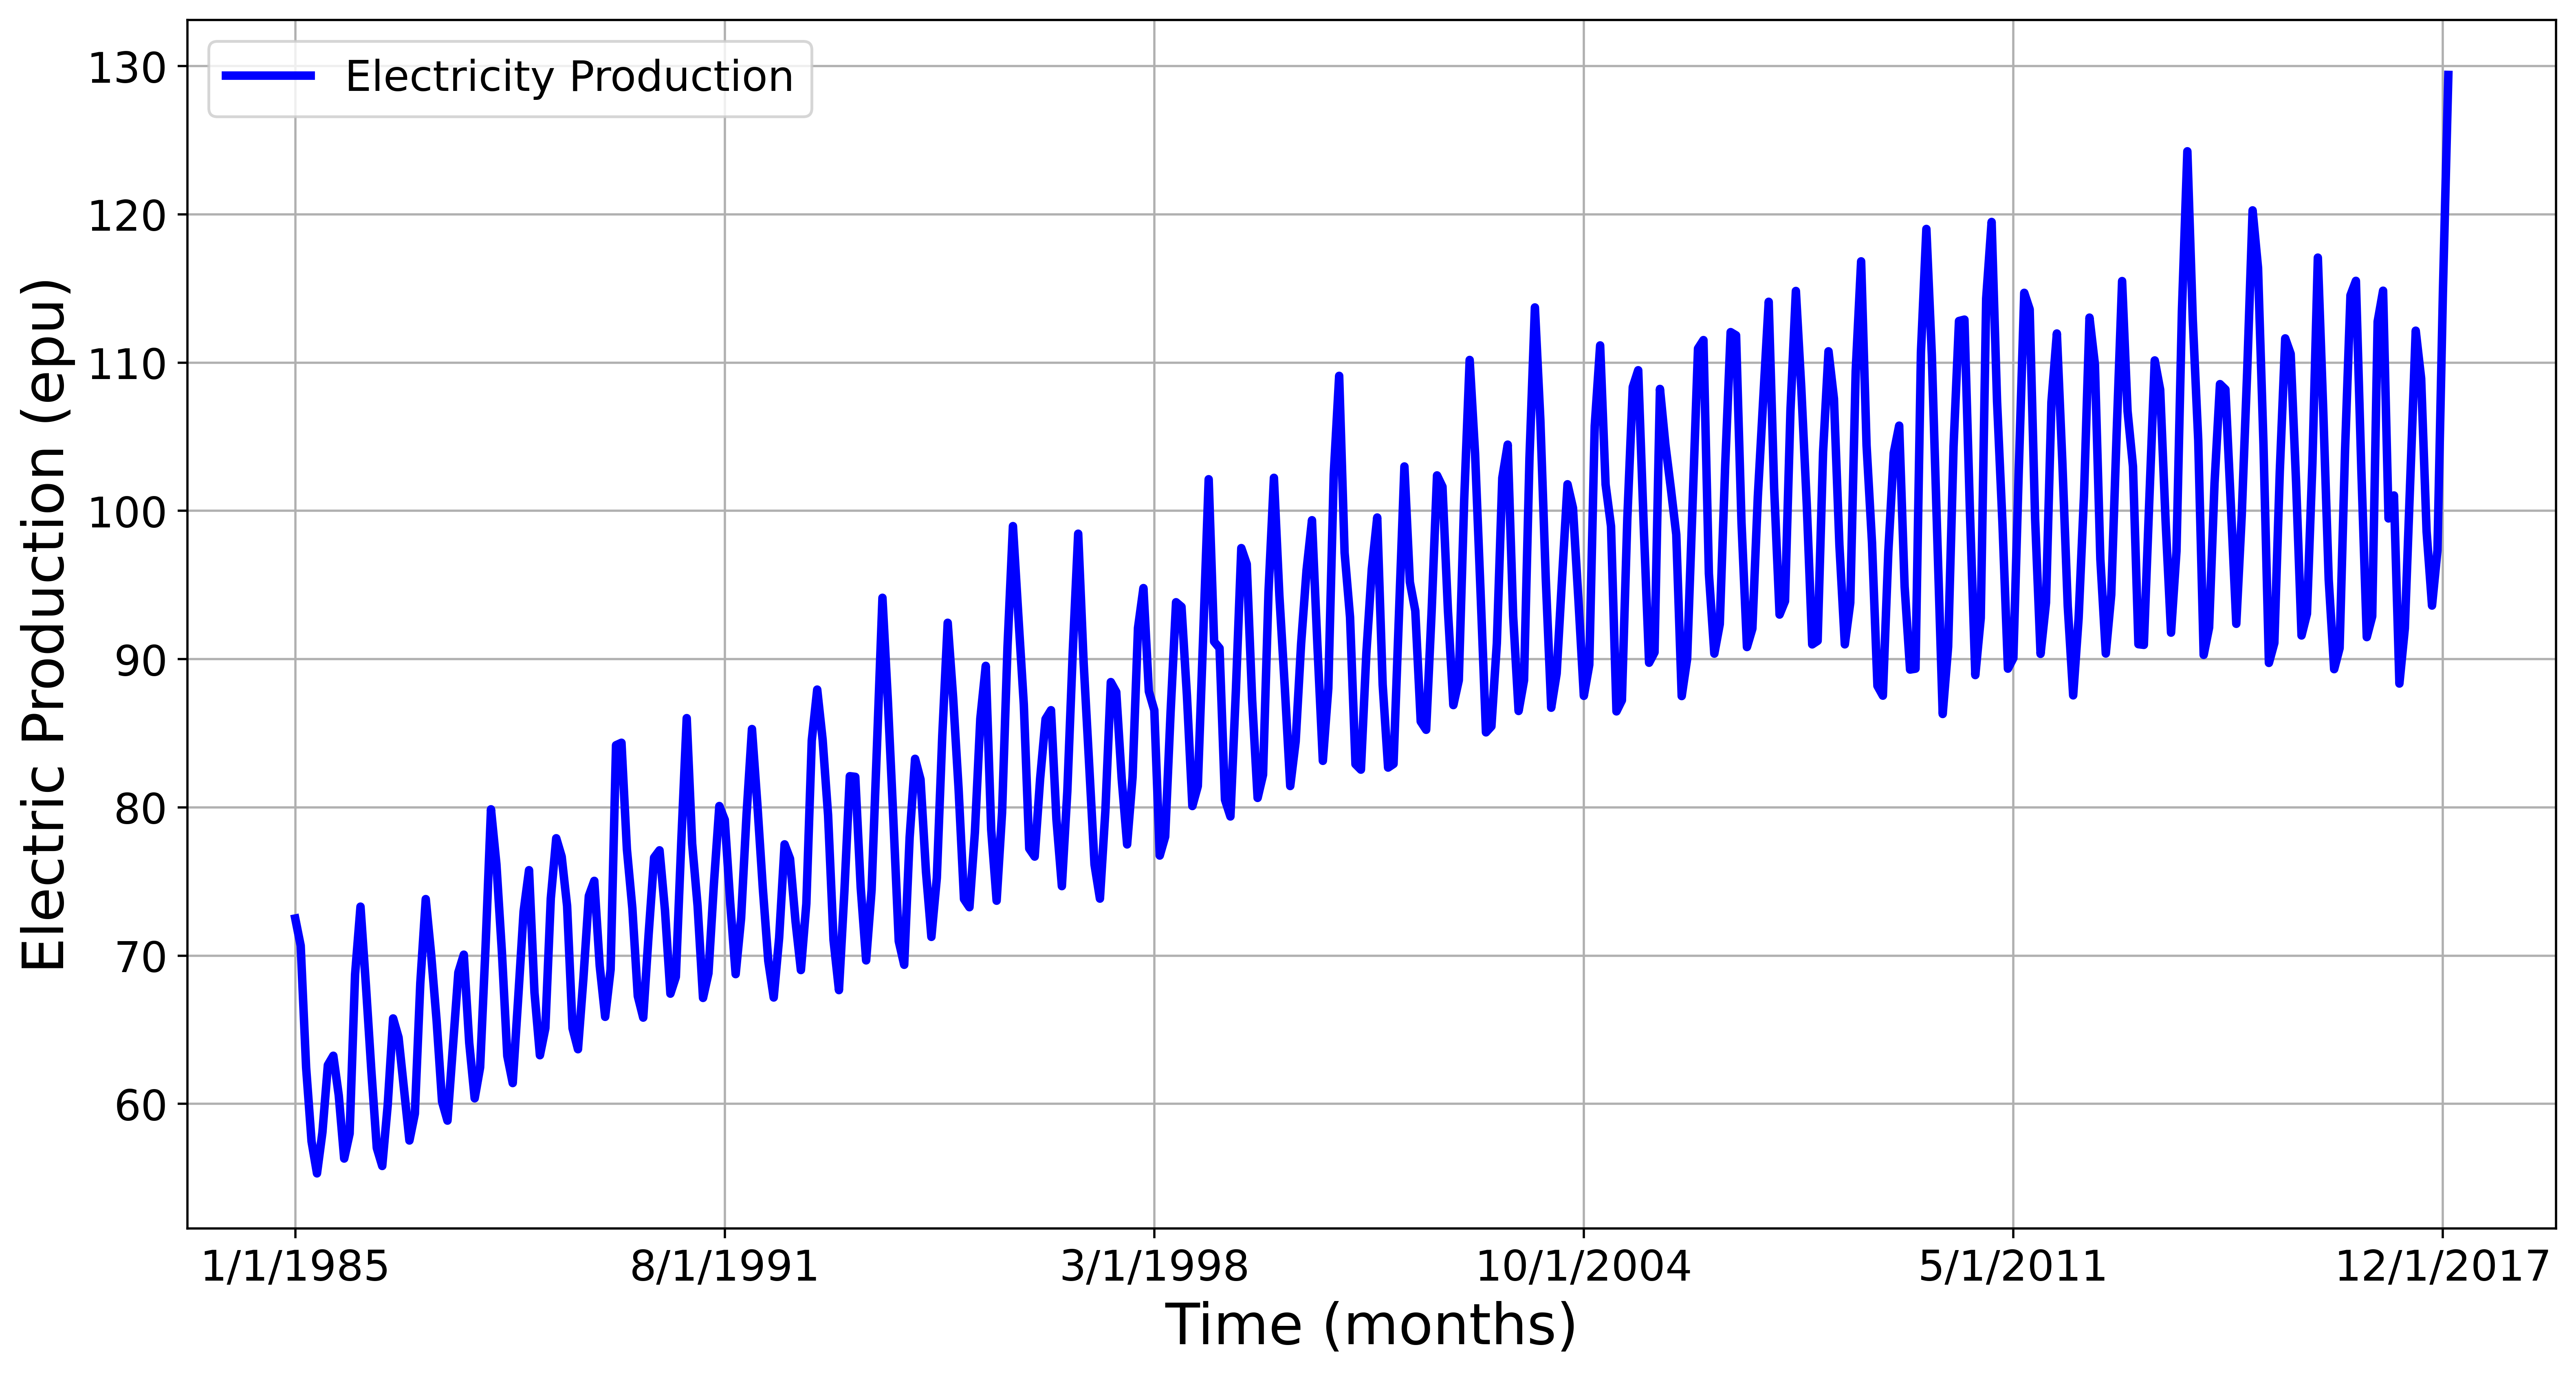

In [7]:
plt.figure(figsize=(15,7.7), dpi=500)
plt.xticks(fontsize=15)
plt.xticks(np.arange(0, len(data)+1, np.round(len(data)/5)))
plt.yticks(fontsize=15)
plt.grid()

plt.xlabel("Time (months)", fontsize=20)
plt.ylabel("Electric Production (epu)", fontsize=20)
plt.plot(data['Date'], data['Production'], 'b', label='Electricity Production', linewidth=3)
plt.legend(fontsize=15)

#plt.savefig('eletric_production_dataset.eps', format='eps', bbox_inches='tight')

In [8]:
#RMSE and MAE Individual
RMSE_LSTM = []
MAE_LSTM = []

In [9]:
# Variables
window_ = 3
actList_ = 'linear'
optList_ = 'adam'

n_features = 1
n_Units = 100
n_Epochs = 100

In [10]:
X_train, y_train, X_test, y_test = dataSpliting(pdSeries = dataSeries, window=window_, N_splits = 5)

#LSTM
# define model
lstm_model = Sequential()
lstm_model.add(LSTM(n_Units, activation=actList_, return_sequences=True, input_shape=(window_, 1)))
lstm_model.add(LSTM(n_Units, activation=actList_))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=optList_, loss='mse')

# fit model
lstm_model.fit(X_train, y_train, epochs=n_Epochs, verbose=0)

#model predict
y_predict_lstm = lstm_model.predict(X_test, verbose=0)

y_pred_lstm = []
for y in y_predict_lstm:
    y_pred_lstm.append(y[0])

# Calculating rmse:
rmse_lstm = mean_squared_error(y_test[1:-2], y_pred_lstm[2:-1], squared=False)
RMSE_LSTM.append(rmse_lstm)        

# Calculating mae:
mae_lstm = mean_absolute_error(y_test[1:-2], y_pred_lstm[2:-1])
MAE_LSTM.append(mae_lstm)


c:\Users\Samsung\anaconda3\envs\env\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\Samsung\anaconda3\envs\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [11]:
figure2 = make_subplots(specs=[[{"secondary_y": True}]])

figure2.add_trace(
    go.Scatter(y=y_test[1:-2], name='True'),
    secondary_y=False
)

figure2.add_trace(
    go.Scatter(y=y_pred_lstm[2:-1], name='LSTM'),
    secondary_y=False
)

figure2.update_layout(
    title="Comparison "
)

figure2.update_xaxes(title='Time (seconds)')

figure2.show()

## WandB importing:

In [ ]:
#!pip install wandb

In [ ]:
os.environ["WANDB__SERVICE_WAIT"] = "1000000"

In [ ]:
!wandb login 40f0acf51f839c9bfbed5c1f24e945ed8245e110

In [ ]:
# Initialize a new W&B run to track this job
run = wandb.init(project="TEDARegressor", job_type="dataset-creation")

In [ ]:
# Create a new artifact, which is a sample dataset
dataset = wandb.Artifact('Electric_Production.csv', type='dataset')
# Add files to the artifact, in this case a simple text file
dataset.add_file('Electric_Production.csv')
# Log the artifact to save it as an output of this run
run.log_artifact(dataset)

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

### Defining dictionaries:

In [ ]:
metric_dict = {
    'name': 'rmse_lstm',
    'goal': 'minimize'   
    }

parameters_dict = {
    #LSTM
    'Window': {
      'values': [3] #5 = 5
    },
    'n_Units': {
      'values': [100] #5x3 = 15
    },
    'n_Epochs': {
      'values': [100] #5x3x2 = 30
    },
    'ActList': {
        'values': ['relu'] #5x3x2x2 = 60
        },             
}

In [ ]:
parameters_dict = {
    #LSTM
    'Window': {
      'values': [2,3,4,5,6] #5 = 5
    },
    'n_Units': {
      'values': [10, 50, 100] #5x3 = 15
    },
    'n_Epochs': {
      'values': [100, 200] #5x3x2 = 30
    },
    'ActList': {
        'values': ['relu', 'linear'] #5x3x2x2 = 60
        },             
}

In [ ]:
seed = 41
sweep_config = {
    "method": "grid",
    "metric": metric_dict,
    "parameters": parameters_dict,

}
sweep_id = wandb.sweep(sweep_config, project="TEDARegressor")

In [ ]:
#LSTM
RMSE_LSTM = []
MAE_LSTM = []

In [ ]:
def train():
    with wandb.init() as run:

        X_train, y_train, X_test, y_test = dataSpliting(pdSeries = dataSeries, window=wandb.config.Window, N_splits = 5)

        #LSTM
        # define model
        lstm_model = Sequential()
        lstm_model.add(LSTM(wandb.config.n_Units, activation=wandb.config.ActList, return_sequences=True, input_shape=(wandb.config.Window, 1)))
        lstm_model.add(LSTM(wandb.config.n_Units, activation=wandb.config.ActList))
        lstm_model.add(Dense(1))
        lstm_model.compile(optimizer='adam', loss='mse')

        # fit model
        lstm_model.fit(X_train, y_train, epochs=wandb.config.n_Epochs, verbose=0)

        # create codecarbon tracker
        # codecarbon is too much verbose, change the log level for more info
        tracker = EmissionsTracker(log_level="critical")
        tracker.start()   

        #model predict
        y_predict_lstm = lstm_model.predict(X_test, verbose=0)

        # get co2 emissions from tracker
        # "CO2 emission (in Kg)"
        emissions = tracker.stop()
        # energy unit is kWh
        run.summary["Energy_Consumed"] = tracker.final_emissions_data.energy_consumed
        wandb.log({"Energy_Consumed": tracker.final_emissions_data.energy_consumed})  

        y_pred_lstm = []
        for y in y_predict_lstm:
            y_pred_lstm.append(y[0])

        # Calculating rmse:
        rmse_lstm = mean_squared_error(y_test[1:-2], y_pred_lstm[2:-1], squared=False)
        RMSE_LSTM.append(rmse_lstm) 
        run.summary['rmse_lstm'] = rmse_lstm
        wandb.log({"rmse_lstm": rmse_lstm})       

        # Calculating mae:
        mae_lstm = mean_absolute_error(y_test[1:-2], y_pred_lstm[2:-1])
        MAE_LSTM.append(mae_lstm)
        run.summary['mae_lstm'] = mae_lstm
        wandb.log({"mae_lstm": mae_lstm}) 
      

In [ ]:
wandb.agent(sweep_id, train)

# Sweep Analysis

## Visualization

Here, we can visualize the Sweep Results 👀. We have use the **Parallel Coordinates Plot 🔀** to map hyperparameter values to model metrics.
We've used to see the combinations of hyperparameters that led to the **best model performance 📊**:


#### Sweep Data

![SweepData](results/LSTMtoCompareWithTEDAEnsemble.png)

#### Now, we are going to look the model results:

In [12]:
df_lstm_sweep = pd.read_csv("results/LSTMtoCompareWithTEDAEnsemble.csv")
df_lstm_sweep.head()

,Name,Window,n_Units,n_Epochs,ActList,rmse_lstm,mae_lstm,Energy_Consumed
0,ethereal-sweep-6,2,100,200,relu,5.705199,4.769030,0.000001
1,fragrant-sweep-5,2,50,200,relu,7.214670,5.829197,0.000001
2,solar-sweep-32,2,50,100,linear,7.461478,6.059737,0.000001
3,comic-sweep-2,2,50,100,relu,7.687972,6.467680,0.000001
4,apricot-sweep-33,2,100,100,linear,6.647504,5.536965,0.000001


### RMSE

In [13]:
min(df_lstm_sweep['rmse_lstm'])

2.249301595263072

### Best hyperparameter setup:

In [14]:
df_lstm_sweep[df_lstm_sweep['rmse_lstm']==min(df_lstm_sweep['rmse_lstm'])]

,Name,Window,n_Units,n_Epochs,ActList,rmse_lstm,mae_lstm,Energy_Consumed
22,curious-sweep-7,3,10,100,relu,2.249302,1.801173,0.000001


In [15]:
np.mean(df_lstm_sweep['rmse_lstm'])

8.074360412857727

In [16]:
max(df_lstm_sweep['rmse_lstm'])

10.254090696325749

### MAE

In [17]:
min(df_lstm_sweep['mae_lstm'])

1.801172987021169

In [18]:
np.mean(df_lstm_sweep['mae_lstm'])

7.020675616051459

In [19]:
max(df_lstm_sweep['mae_lstm'])

8.423755780619958

### Energy Consumed

In [20]:
min(df_lstm_sweep['Energy_Consumed'])

1.2237952519e-06

In [21]:
np.mean(df_lstm_sweep['Energy_Consumed'])

1.4626130878216668e-06

In [22]:
max(df_lstm_sweep['Energy_Consumed'])

3.4891150883e-06